# This Notebook is for predicting the Voice Activity from a set of voiced audio signal using Neural Networks

Import main libraries

In [1]:
import os
import sys
import numpy as np
from scipy.io import wavfile

In [2]:
os.listdir()

['LibriSpeech',
 'DLIVING',
 'sample.sh',
 'venv',
 'mfcc',
 'test-clean',
 '__init__.py',
 'DWASHING',
 '.ipynb_checkpoints',
 'DKITCHEN',
 '__pycache__',
 'how_to_VAD.ipynb',
 'model',
 'how_to_VAD_linux.ipynb',
 'OOFFICE',
 'prepare_noise.py',
 'rnn_model',
 '.idea',
 'MelFrequency.py']

In [3]:
all_files = os.listdir('LibriSpeech/dev-clean/')

In [4]:
os.chdir('../VAD/LibriSpeech/dev-clean/')

## Reading Audio files (for signal) and Noise from LibriSpeech

In [5]:
def read_flacs(flacfile):
    data , fs = sf.read(flacfile)
    return (data,fs)

In [6]:
def get_all_audios():
    all_flacs = []
    for f in os.listdir():
        print('parent: ',f)
        for f1 in os.listdir(f):
            print("child: ",f1)
            for flacs in os.listdir(os.path.join(f,f1)):
                #print("flacs: ",flacs)
                all_flacs.append(os.path.join(f,f1,flacs))
    return all_flacs

In [7]:
all_flacs = get_all_audios()

parent:  1673
child:  143396
child:  143397
parent:  7850
child:  111771
child:  281318
child:  286674
child:  73752
parent:  2428
child:  83699
child:  83705
parent:  7976
child:  105575
child:  110523
child:  110124
parent:  5895
child:  34622
child:  34615
child:  34629
parent:  777
child:  126732
parent:  422
child:  122949
parent:  5536
child:  43358
child:  43359
child:  43363
parent:  6295
child:  244435
child:  64301
parent:  2086
child:  149220
child:  149214
parent:  8842
child:  302201
child:  302196
child:  304647
child:  302203
parent:  2902
child:  9006
child:  9008
parent:  174
child:  168635
child:  50561
child:  84280
parent:  3170
child:  137482
parent:  6345
child:  93306
child:  93302
child:  64257
parent:  3081
child:  166546
parent:  3000
child:  15664
parent:  8297
child:  275156
child:  275154
child:  275155
parent:  2078
child:  142845
parent:  652
child:  129742
child:  130726
child:  130737
parent:  1988
child:  147956
child:  24833
child:  148538
parent:  20

In [8]:
#!pip install soundfile

In [9]:
import soundfile as sf

all_flacs[0]


'1673/143396/1673-143396-0018.flac'

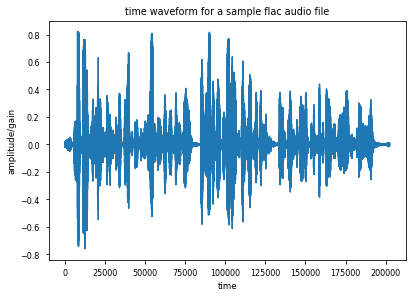

In [82]:
import matplotlib.pyplot as plt
def visualize_sample_audio(data):
    plt.xlabel('time')
    plt.ylabel('amplitude/gain')
    plt.title('time waveform for a sample flac audio file')
    
    plt.plot(data)
    plt.show()

visualize_sample_audio(read_flacs('/home/bhargav/Documents/VAD/LibriSpeech/dev-clean/'+all_flacs[0])[0])

In [10]:
os.getcwd()

'/home/bhargav/Documents/VAD/LibriSpeech/dev-clean'

# Feature Extraction of raw audio samples

In [11]:
def divide_frames_each_file(data,fs = 16000):
    window_dur = 32e-3
    num_samples = data.shape[0]
    audio_dur = num_samples/fs
    num_of_frames=int(np.floor(audio_dur/window_dur))
    frame_length = int(window_dur * fs)
    
    samples_left = num_samples-(num_of_frames*frame_length)
    leading_zeros=np.zeros((abs(samples_left-frame_length),))
    
    padded_data=np.concatenate((data,leading_zeros),axis=0)
    frames_divided=np.reshape(padded_data,[-1, frame_length])
    
    return frames_divided

In [12]:
#os.chdir('..\\..\\')
import os
import random

In [13]:
os.getcwd()

'/home/bhargav/Documents/VAD/LibriSpeech/dev-clean'

# Use noise samples by selecting an audio frame by picking from file randomly 

In [18]:
os.chdir('../..')
assert os.getcwd().split('/')[-1] == "VAD"  #To make sure the directory we're in is: VAD so we have access to the noise folders
noises = ['OOFFICE','DLIVING','DKITCHEN','DWASHING']
random.seed(random.randint(0,12345))

def read_noise_files(filepath):
    fs,noise_wavs = wavfile.read(filepath)
    print('file read..')
    ret_arr = normalize(noise_wavs)
    return ret_arr

def pick_random_recording():
    real_noise = random.choice(noises)
    print('picked dataset',real_noise)
    return real_noise


def pick_random_noise_file(real_noise):
    wav_seq = [str(i).zfill(2) for i in range(1, 17)]
    noise_wavfile = str(real_noise) + '/ch' + random.choice(wav_seq) + '.wav'
    print('picked file: ',noise_wavfile)
    return noise_wavfile

def normalize(data):
    return minmax_scale(data)


In [19]:
def noise_wrapper():
    noise_wavfile = pick_random_noise_file(real_noise=pick_random_recording())
    noisy = read_noise_files(os.path.join(os.getcwd(), noise_wavfile))
    normalized_noisy = normalize(data=noisy)
    return divide_frames_each_file(data=normalized_noisy)

In [20]:
from sklearn.preprocessing import minmax_scale

In [21]:
framed_noise = noise_wrapper()

picked dataset DWASHING
picked file:  DWASHING/ch16.wav
file read..


/home/bhargav/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [22]:
framed_noise.min() #sample from one of the files.. all noise signals extracted from different recordings are of same size

0.0

In [23]:
def norm_squared(X):
    return np.square(np.linalg.norm(X,axis=1))

In [24]:
import random

# Extract MFCCs from time series data

In [25]:
from scipy.fftpack import idct, dct, fft2, ifft2, fft,ifft

#Hard-coded for now

NFFT = 512
fs = 16000
n_dct = 60


def hz2mel(hz):
    mel=2595*np.log10(1+hz/700)
    return mel


def mel2hz(mel):
    hz=700*(10**(mel/2595)-1)
    return hz

f_bank_length=60

mel_max=hz2mel(hz=fs)
mel_scale=np.linspace(0,mel_max,f_bank_length)
hz_scale=mel2hz(mel_scale)


bins=np.floor((NFFT) * hz_scale / fs)




def compute_fft(time_data):
    freq_samples = fft(time_data, NFFT, axis = 1)
    pow_samples=np.absolute(freq_samples)**2
    pow_samples = pow_samples / pow_samples.max()
    pow_db = np.log10(pow_samples)
    pow_db[pow_db < -5] = -5
    return pow_db


def prepare_mel_filter():
    H_filt_resp = np.zeros((f_bank_length, NFFT))
    for k in range(0,f_bank_length-2):
        fm_plus=int(bins[k+2])
        fm=int(bins[k+1])
        fm_minus=int(bins[k])

        for m in range(fm_minus,fm):
            H_filt_resp[k,m]=(m-fm_minus)/(fm-fm_minus)
        for m in range(fm,fm_plus):
            H_filt_resp[k,m]=(fm_plus-m)/(fm_plus-fm)
    H_filt_resp = np.where( H_filt_resp == 0, np.finfo(float).eps, H_filt_resp)
    return H_filt_resp

def get_mfcc(data_block):
    H_filt_resp = prepare_mel_filter()
    pow_db = compute_fft(data_block)
    num_of_frames = pow_db.shape[0]
    Y_bank_out = np.dot(pow_db,H_filt_resp.T)
    y_coeff = np.empty((num_of_frames, n_dct))
    for row in range(Y_bank_out.shape[0]):
        y_coeff[row, :] = dct(Y_bank_out[row, :], type=2, n=n_dct, norm='ortho')
    ncoeff = y_coeff.shape[1]
    n = np.arange(0, ncoeff)
    cep_lifter = 0.001 * ncoeff
    lift = 1 + (ncoeff) * np.sin(np.pi * n / cep_lifter)
    mfcc = y_coeff * lift
    mfcc -= (np.mean(y_coeff, axis=0))
    return mfcc

In [26]:
os.getcwd()

'/home/bhargav/Documents/VAD'

 # Prepare X(l) from clean and noise signals
 # Compute soft VAD values
 # Convert to cepstral domain and store them in binary files.
 # You can find them in 'VAD/mfcc/' directory

In [27]:

def array_to_binary_file(data, output_file_name):
    data = np.array(data, 'float32')
    save_file = os.path.splitext(output_file_name)[0]
    fid = open(save_file, 'wb')
    data.tofile(fid)
    fid.close()

In [28]:
def prepare_input_files(all_flacs):
    summ_frames = 0
    v_labels = np.empty((700000,))
    alpha = 1
    if not os.path.exists(path=os.path.join(os.getcwd(),'mfcc')):
        os.mkdir(os.path.join(os.getcwd(),'mfcc'))
    for i,flac in enumerate(all_flacs):
        print(os.path.splitext(flac))
        if os.path.splitext(flac)[1] == ".flac":
            st_index = random.randint(0,8000)
            flacpath = os.path.join('LibriSpeech/dev-clean/',flac)
            data,fs = read_flacs(flacpath)
            assert fs == 16000
            framed_data = divide_frames_each_file(data,fs)
            #print(framed_data)
            framed_noise = noise_wrapper()[st_index:st_index+framed_data.shape[0]]
            X_l =framed_data+alpha*framed_noise
            mfcc = get_mfcc(X_l)
            array_to_binary_file(mfcc,os.path.join('mfcc',flac.split('/')[-1]))
            v_labels[summ_frames:summ_frames+framed_data.shape[0]] = norm_squared(framed_data)/(norm_squared(framed_data)+norm_squared(framed_noise))
            summ_frames += framed_data.shape[0]
            print("picked and processed", summ_frames ,"frames so far: " )
    return summ_frames, v_labels

In [29]:
total_frames, v_labels = prepare_input_files(all_flacs)

('1673/143396/1673-143396-0018', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch10.wav
file read..
picked and processed 396 frames so far: 
('1673/143396/1673-143396-0005', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch02.wav
file read..
picked and processed 763 frames so far: 
('1673/143396/1673-143396-0020', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch03.wav
file read..
picked and processed 1233 frames so far: 
('1673/143396/1673-143396-0004', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch16.wav
file read..
picked and processed 1856 frames so far: 
('1673/143396/1673-143396-0010', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch16.wav
file read..
picked and processed 2231 frames so far: 
('1673/143396/1673-143396-0015', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 2429 frames so far: 
('1673/143396/1673-143396-0011', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch09.

picked and processed 17734 frames so far: 
('7850/281318/7850-281318-0008', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch12.wav
file read..
picked and processed 17925 frames so far: 
('7850/281318/7850-281318-0013', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch04.wav
file read..
picked and processed 18114 frames so far: 
('7850/281318/7850-281318-0016', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch09.wav
file read..
picked and processed 18218 frames so far: 
('7850/281318/7850-281318-0010', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch03.wav
file read..
picked and processed 18595 frames so far: 
('7850/281318/7850-281318-0018', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch06.wav
file read..
picked and processed 18743 frames so far: 
('7850/281318/7850-281318-0000', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch01.wav
file read..
picked and processed 18874 frames so far: 
('7850/281318/7850-281318-0005', '.flac')
p

picked and processed 29159 frames so far: 
('7850/73752/7850-73752-0009', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch01.wav
file read..
picked and processed 29389 frames so far: 
('7850/73752/7850-73752-0017', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch12.wav
file read..
picked and processed 29576 frames so far: 
('7850/73752/7850-73752-0002', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 29861 frames so far: 
('7850/73752/7850-73752-0005', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch16.wav
file read..
picked and processed 29928 frames so far: 
('7850/73752/7850-73752-0001', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch09.wav
file read..
picked and processed 30181 frames so far: 
('7850/73752/7850-73752-0016', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch03.wav
file read..
picked and processed 30294 frames so far: 
('2428/83699/2428-83699-0002', '.flac')
picked dataset 

picked and processed 38333 frames so far: 
('2428/83705/2428-83705-0037', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch04.wav
file read..
picked and processed 38626 frames so far: 
('2428/83705/2428-83705-0002', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch03.wav
file read..
picked and processed 39141 frames so far: 
('2428/83705/2428-83705-0041', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch15.wav
file read..
picked and processed 39265 frames so far: 
('2428/83705/2428-83705-0009', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch14.wav
file read..
picked and processed 39332 frames so far: 
('2428/83705/2428-83705-0024', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch09.wav
file read..
picked and processed 39487 frames so far: 
('2428/83705/2428-83705-0022', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 39660 frames so far: 
('2428/83705/2428-83705.trans', '.txt')
('2428/83705/2428-8

picked and processed 48658 frames so far: 
('7976/105575/7976-105575-0010', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch04.wav
file read..
picked and processed 48800 frames so far: 
('7976/105575/7976-105575-0018', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 48935 frames so far: 
('7976/105575/7976-105575-0020', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch06.wav
file read..
picked and processed 49001 frames so far: 
('7976/105575/7976-105575-0027', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch03.wav
file read..
picked and processed 49210 frames so far: 
('7976/105575/7976-105575-0009', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch10.wav
file read..
picked and processed 49337 frames so far: 
('7976/105575/7976-105575.trans', '.txt')
('7976/105575/7976-105575-0022', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch01.wav
file read..
picked and processed 49506 frames so far: 
('7

picked and processed 59140 frames so far: 
('7976/110124/7976-110124-0008', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch16.wav
file read..
picked and processed 59306 frames so far: 
('7976/110124/7976-110124-0010', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch04.wav
file read..
picked and processed 59513 frames so far: 
('7976/110124/7976-110124-0003', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch11.wav
file read..
picked and processed 59802 frames so far: 
('7976/110124/7976-110124-0006', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch04.wav
file read..
picked and processed 60134 frames so far: 
('7976/110124/7976-110124-0015', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch08.wav
file read..
picked and processed 60302 frames so far: 
('7976/110124/7976-110124-0002', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch07.wav
file read..
picked and processed 60548 frames so far: 
('7976/110124/7976-110124-0021', '.flac')
picke

picked and processed 70248 frames so far: 
('5895/34629/5895-34629-0026', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch08.wav
file read..
picked and processed 70671 frames so far: 
('5895/34629/5895-34629-0003', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch13.wav
file read..
picked and processed 70770 frames so far: 
('5895/34629/5895-34629-0002', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch01.wav
file read..
picked and processed 70893 frames so far: 
('5895/34629/5895-34629-0013', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch12.wav
file read..
picked and processed 71050 frames so far: 
('5895/34629/5895-34629-0030', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch13.wav
file read..
picked and processed 71368 frames so far: 
('5895/34629/5895-34629-0008', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch12.wav
file read..
picked and processed 71691 frames so far: 
('5895/34629/5895-34629-0031', '.flac')
picked datase

picked and processed 79777 frames so far: 
('777/126732/777-126732-0053', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch03.wav
file read..
picked and processed 79923 frames so far: 
('777/126732/777-126732-0038', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch06.wav
file read..
picked and processed 80020 frames so far: 
('777/126732/777-126732-0037', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch16.wav
file read..
picked and processed 80191 frames so far: 
('777/126732/777-126732-0049', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch16.wav
file read..
picked and processed 80262 frames so far: 
('777/126732/777-126732-0002', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch15.wav
file read..
picked and processed 80421 frames so far: 
('777/126732/777-126732-0039', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch08.wav
file read..
picked and processed 80510 frames so far: 
('777/126732/777-126732-0024', '.flac')
picked dataset DL

/home/bhargav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


picked and processed 80936 frames so far: 
('777/126732/777-126732-0063', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch10.wav
file read..
picked and processed 81504 frames so far: 
('777/126732/777-126732-0058', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch09.wav
file read..
picked and processed 81668 frames so far: 
('777/126732/777-126732-0059', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch03.wav
file read..
picked and processed 81861 frames so far: 
('777/126732/777-126732-0070', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch05.wav
file read..
picked and processed 82090 frames so far: 
('777/126732/777-126732-0057', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch04.wav
file read..
picked and processed 82433 frames so far: 
('777/126732/777-126732-0051', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch15.wav
file read..
picked and processed 82569 frames so far: 
('777/126732/777-126732-0071', '.flac')
picked dataset 

picked and processed 91624 frames so far: 
('422/122949/422-122949-0035', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch10.wav
file read..
picked and processed 91771 frames so far: 
('422/122949/422-122949-0026', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch12.wav
file read..
picked and processed 92181 frames so far: 
('422/122949/422-122949-0019', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch16.wav
file read..
picked and processed 92779 frames so far: 
('422/122949/422-122949-0013', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch05.wav
file read..
picked and processed 93800 frames so far: 
('422/122949/422-122949-0006', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch06.wav
file read..
picked and processed 94247 frames so far: 
('422/122949/422-122949-0017', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch06.wav
file read..
picked and processed 94316 frames so far: 
('422/122949/422-122949-0014', '.flac')
picked dataset 

picked and processed 111928 frames so far: 
('5536/43359/5536-43359-0002', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch02.wav
file read..
picked and processed 112273 frames so far: 
('5536/43359/5536-43359.trans', '.txt')
('5536/43359/5536-43359-0017', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch09.wav
file read..
picked and processed 112446 frames so far: 
('5536/43359/5536-43359-0008', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch13.wav
file read..
picked and processed 112531 frames so far: 
('5536/43359/5536-43359-0003', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch03.wav
file read..
picked and processed 112915 frames so far: 
('5536/43359/5536-43359-0016', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch12.wav
file read..
picked and processed 113105 frames so far: 
('5536/43359/5536-43359-0000', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 113210 frames so far: 
('55

picked and processed 124532 frames so far: 
('6295/244435/6295-244435-0017', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch06.wav
file read..
picked and processed 124800 frames so far: 
('6295/244435/6295-244435-0038', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch13.wav
file read..
picked and processed 125092 frames so far: 
('6295/244435/6295-244435-0022', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch05.wav
file read..
picked and processed 125332 frames so far: 
('6295/244435/6295-244435-0018', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch03.wav
file read..
picked and processed 125499 frames so far: 
('6295/244435/6295-244435-0008', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch14.wav
file read..
picked and processed 125918 frames so far: 
('6295/244435/6295-244435-0011', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch04.wav
file read..
picked and processed 125997 frames so far: 
('6295/244435/6295-244435-0034', '.f

picked and processed 136125 frames so far: 
('6295/64301/6295-64301-0017', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch16.wav
file read..
picked and processed 136297 frames so far: 
('6295/64301/6295-64301-0032', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch02.wav
file read..
picked and processed 136378 frames so far: 
('6295/64301/6295-64301-0025', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch05.wav
file read..
picked and processed 136557 frames so far: 
('6295/64301/6295-64301-0014', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch01.wav
file read..
picked and processed 136700 frames so far: 
('6295/64301/6295-64301-0011', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch12.wav
file read..
picked and processed 137016 frames so far: 
('2086/149220/2086-149220-0028', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch03.wav
file read..
picked and processed 137106 frames so far: 
('2086/149220/2086-149220-0015', '.flac')
pick

picked and processed 150033 frames so far: 
('2086/149220/2086-149220-0008', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch06.wav
file read..
picked and processed 150311 frames so far: 
('2086/149214/2086-149214.trans', '.txt')
('2086/149214/2086-149214-0002', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch07.wav
file read..
picked and processed 150835 frames so far: 
('2086/149214/2086-149214-0001', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch01.wav
file read..
picked and processed 151053 frames so far: 
('2086/149214/2086-149214-0000', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch12.wav
file read..
picked and processed 151360 frames so far: 
('2086/149214/2086-149214-0004', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch01.wav
file read..
picked and processed 151836 frames so far: 
('2086/149214/2086-149214-0003', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch05.wav
file read..
picked and processed 152118 frames so fa

picked and processed 165024 frames so far: 
('8842/302203/8842-302203-0008', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch06.wav
file read..
picked and processed 165162 frames so far: 
('8842/302203/8842-302203-0006', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch01.wav
file read..
picked and processed 165328 frames so far: 
('8842/302203/8842-302203-0005', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch13.wav
file read..
picked and processed 165587 frames so far: 
('8842/302203/8842-302203-0001', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch01.wav
file read..
picked and processed 165884 frames so far: 
('8842/302203/8842-302203-0011', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch07.wav
file read..
picked and processed 166095 frames so far: 
('8842/302203/8842-302203-0009', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch11.wav
file read..
picked and processed 166473 frames so far: 
('8842/302203/8842-302203-0010', '.flac'

picked and processed 184511 frames so far: 
('174/168635/174-168635-0002', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch13.wav
file read..
picked and processed 185007 frames so far: 
('174/168635/174-168635-0011', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch03.wav
file read..
picked and processed 185153 frames so far: 
('174/168635/174-168635-0014', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch16.wav
file read..
picked and processed 185304 frames so far: 
('174/168635/174-168635-0022', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch03.wav
file read..
picked and processed 185440 frames so far: 
('174/168635/174-168635-0001', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch10.wav
file read..
picked and processed 185586 frames so far: 
('174/168635/174-168635-0016', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch15.wav
file read..
picked and processed 185807 frames so far: 
('174/168635/174-168635-0018', '.flac')
picked dat

picked and processed 198286 frames so far: 
('3170/137482/3170-137482-0005', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch13.wav
file read..
picked and processed 198559 frames so far: 
('3170/137482/3170-137482-0037', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch14.wav
file read..
picked and processed 198739 frames so far: 
('3170/137482/3170-137482-0002', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch09.wav
file read..
picked and processed 199357 frames so far: 
('3170/137482/3170-137482-0000', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch06.wav
file read..
picked and processed 200232 frames so far: 
('3170/137482/3170-137482-0030', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 200432 frames so far: 
('3170/137482/3170-137482-0023', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch09.wav
file read..
picked and processed 200817 frames so far: 
('3170/137482/3170-137482-0040', '.fla

picked and processed 214604 frames so far: 
('6345/93306/6345-93306-0021', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch04.wav
file read..
picked and processed 214723 frames so far: 
('6345/93306/6345-93306-0003', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch14.wav
file read..
picked and processed 214801 frames so far: 
('6345/93306/6345-93306-0001', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch13.wav
file read..
picked and processed 215253 frames so far: 
('6345/93306/6345-93306-0020', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch08.wav
file read..
picked and processed 215464 frames so far: 
('6345/93306/6345-93306-0011', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch05.wav
file read..
picked and processed 215600 frames so far: 
('6345/93306/6345-93306-0012', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch15.wav
file read..
picked and processed 215681 frames so far: 
('6345/93306/6345-93306-0009', '.flac')
picked datas

picked and processed 225395 frames so far: 
('6345/64257/6345-64257-0016', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch15.wav
file read..
picked and processed 225576 frames so far: 
('6345/64257/6345-64257-0010', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 225701 frames so far: 
('6345/64257/6345-64257.trans', '.txt')
('6345/64257/6345-64257-0017', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch12.wav
file read..
picked and processed 225790 frames so far: 
('6345/64257/6345-64257-0005', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch15.wav
file read..
picked and processed 226030 frames so far: 
('6345/64257/6345-64257-0019', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 226272 frames so far: 
('6345/64257/6345-64257-0009', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch11.wav
file read..
picked and processed 226660 frames so far: 
('6345/642

picked and processed 234389 frames so far: 
('3081/166546/3081-166546-0083', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch14.wav
file read..
picked and processed 234479 frames so far: 
('3081/166546/3081-166546-0045', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch15.wav
file read..
picked and processed 234776 frames so far: 
('3081/166546/3081-166546-0011', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch14.wav
file read..
picked and processed 234971 frames so far: 
('3081/166546/3081-166546-0079', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch06.wav
file read..
picked and processed 235229 frames so far: 
('3081/166546/3081-166546-0049', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch01.wav
file read..
picked and processed 235339 frames so far: 
('3081/166546/3081-166546-0017', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch14.wav
file read..
picked and processed 235465 frames so far: 
('3081/166546/3081-166546-0040', '.f

picked and processed 243975 frames so far: 
('3000/15664/3000-15664-0025', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch05.wav
file read..
picked and processed 244131 frames so far: 
('3000/15664/3000-15664-0045', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch06.wav
file read..
picked and processed 244533 frames so far: 
('3000/15664/3000-15664-0001', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch13.wav
file read..
picked and processed 245185 frames so far: 
('3000/15664/3000-15664-0021', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch14.wav
file read..
picked and processed 245584 frames so far: 
('3000/15664/3000-15664-0027', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch13.wav
file read..
picked and processed 245711 frames so far: 
('3000/15664/3000-15664-0019', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch15.wav
file read..
picked and processed 246262 frames so far: 
('3000/15664/3000-15664-0033', '.flac')
picked d

picked and processed 260835 frames so far: 
('8297/275156/8297-275156-0011', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch04.wav
file read..
picked and processed 260997 frames so far: 
('8297/275156/8297-275156-0007', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch04.wav
file read..
picked and processed 261304 frames so far: 
('8297/275156/8297-275156-0005', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch14.wav
file read..
picked and processed 261779 frames so far: 
('8297/275154/8297-275154-0005', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch07.wav
file read..
picked and processed 261866 frames so far: 
('8297/275154/8297-275154-0009', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 261944 frames so far: 
('8297/275154/8297-275154-0007', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch05.wav
file read..
picked and processed 262085 frames so far: 
('8297/275154/8297-275154-0001', '.f

picked and processed 271361 frames so far: 
('8297/275155/8297-275155-0014', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch04.wav
file read..
picked and processed 271625 frames so far: 
('8297/275155/8297-275155-0018', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch03.wav
file read..
picked and processed 271871 frames so far: 
('8297/275155/8297-275155-0011', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch12.wav
file read..
picked and processed 272163 frames so far: 
('8297/275155/8297-275155-0025', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch16.wav
file read..
picked and processed 272263 frames so far: 
('8297/275155/8297-275155-0012', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch05.wav
file read..
picked and processed 272355 frames so far: 
('8297/275155/8297-275155-0031', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch06.wav
file read..
picked and processed 272507 frames so far: 
('8297/275155/8297-275155-0002', '.f

picked and processed 284947 frames so far: 
('2078/142845/2078-142845-0004', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 285672 frames so far: 
('2078/142845/2078-142845-0015', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch09.wav
file read..
picked and processed 285980 frames so far: 
('2078/142845/2078-142845-0006', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch08.wav
file read..
picked and processed 286438 frames so far: 
('2078/142845/2078-142845-0005', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch13.wav
file read..
picked and processed 287419 frames so far: 
('2078/142845/2078-142845-0032', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch14.wav
file read..
picked and processed 287824 frames so far: 
('2078/142845/2078-142845-0029', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch04.wav
file read..
picked and processed 287977 frames so far: 
('2078/142845/2078-142845-0050', '.f

picked and processed 298959 frames so far: 
('652/130726/652-130726-0001', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch16.wav
file read..
picked and processed 299299 frames so far: 
('652/130726/652-130726-0013', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch03.wav
file read..
picked and processed 299466 frames so far: 
('652/130726/652-130726-0008', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch13.wav
file read..
picked and processed 299757 frames so far: 
('652/130726/652-130726-0000', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch11.wav
file read..
picked and processed 299982 frames so far: 
('652/130726/652-130726-0005', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch05.wav
file read..
picked and processed 300309 frames so far: 
('652/130726/652-130726-0021', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch07.wav
file read..
picked and processed 300665 frames so far: 
('652/130726/652-130726-0027', '.flac')
picked dataset

picked and processed 308885 frames so far: 
('1988/147956/1988-147956-0008', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch13.wav
file read..
picked and processed 309352 frames so far: 
('1988/147956/1988-147956-0028', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch15.wav
file read..
picked and processed 309536 frames so far: 
('1988/147956/1988-147956.trans', '.txt')
('1988/24833/1988-24833-0008', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch10.wav
file read..
picked and processed 309614 frames so far: 
('1988/24833/1988-24833-0015', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch07.wav
file read..
picked and processed 309763 frames so far: 
('1988/24833/1988-24833-0027', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch02.wav
file read..
picked and processed 309843 frames so far: 
('1988/24833/1988-24833-0000', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch13.wav
file read..
picked and processed 309947 frames so far: 
('

picked and processed 321960 frames so far: 
('2035/152373/2035-152373.trans', '.txt')
('2035/152373/2035-152373-0017', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch15.wav
file read..
picked and processed 322206 frames so far: 
('2035/152373/2035-152373-0006', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch05.wav
file read..
picked and processed 322447 frames so far: 
('2035/152373/2035-152373-0014', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 322677 frames so far: 
('2035/152373/2035-152373-0016', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch14.wav
file read..
picked and processed 322883 frames so far: 
('2035/152373/2035-152373-0001', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 323404 frames so far: 
('2035/152373/2035-152373-0007', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch08.wav
file read..
picked and processed 323809 frames s

picked and processed 332415 frames so far: 
('2035/147961/2035-147961-0029', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch02.wav
file read..
picked and processed 332532 frames so far: 
('2035/147961/2035-147961-0034', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch10.wav
file read..
picked and processed 332620 frames so far: 
('2035/147961/2035-147961-0006', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch12.wav
file read..
picked and processed 332708 frames so far: 
('2035/147961/2035-147961-0031', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch15.wav
file read..
picked and processed 332819 frames so far: 
('2035/147961/2035-147961-0003', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch01.wav
file read..
picked and processed 332904 frames so far: 
('2035/147961/2035-147961-0027', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch11.wav
file read..
picked and processed 332994 frames so far: 
('2035/147961/2035-147961-0023', '

picked and processed 345058 frames so far: 
('1993/147149/1993-147149-0013', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch12.wav
file read..
picked and processed 345217 frames so far: 
('1993/147965/1993-147965-0005', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch04.wav
file read..
picked and processed 345488 frames so far: 
('1993/147965/1993-147965-0004', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch04.wav
file read..
picked and processed 345580 frames so far: 
('1993/147965/1993-147965-0000', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch07.wav
file read..
picked and processed 345717 frames so far: 
('1993/147965/1993-147965-0008', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch07.wav
file read..
picked and processed 345889 frames so far: 
('1993/147965/1993-147965-0007', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch12.wav
file read..
picked and processed 346126 frames so far: 
('1993/147965/1993-147965-0001', '.flac')


picked and processed 356804 frames so far: 
('1919/142785/1919-142785-0004', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch15.wav
file read..
picked and processed 357060 frames so far: 
('1919/142785/1919-142785-0040', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch08.wav
file read..
picked and processed 357308 frames so far: 
('1919/142785/1919-142785-0041', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch06.wav
file read..
picked and processed 357688 frames so far: 
('1919/142785/1919-142785-0060', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch12.wav
file read..
picked and processed 357920 frames so far: 
('1919/142785/1919-142785-0043', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch10.wav
file read..
picked and processed 358142 frames so far: 
('1919/142785/1919-142785-0023', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch05.wav
file read..
picked and processed 358369 frames so far: 
('1919/142785/1919-142785-0001', '.flac'

picked and processed 370890 frames so far: 
('3536/23268/3536-23268.trans', '.txt')
('3536/23268/3536-23268-0016', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch13.wav
file read..
picked and processed 371244 frames so far: 
('3536/23268/3536-23268-0005', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch09.wav
file read..
picked and processed 371399 frames so far: 
('3536/23268/3536-23268-0003', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch07.wav
file read..
picked and processed 371649 frames so far: 
('3536/23268/3536-23268-0020', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch01.wav
file read..
picked and processed 371970 frames so far: 
('3536/23268/3536-23268-0021', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch07.wav
file read..
picked and processed 372405 frames so far: 
('3536/23268/3536-23268-0007', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch02.wav
file read..
picked and processed 372693 frames so far: 
('3536/23268

picked and processed 385246 frames so far: 
('3576/138058/3576-138058-0040', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch07.wav
file read..
picked and processed 385456 frames so far: 
('3576/138058/3576-138058.trans', '.txt')
('3576/138058/3576-138058-0025', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch03.wav
file read..
picked and processed 385692 frames so far: 
('3576/138058/3576-138058-0012', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch16.wav
file read..
picked and processed 385864 frames so far: 
('3576/138058/3576-138058-0033', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch02.wav
file read..
picked and processed 386420 frames so far: 
('3576/138058/3576-138058-0019', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch16.wav
file read..
picked and processed 386731 frames so far: 
('3576/138058/3576-138058-0004', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch09.wav
file read..
picked and processed 387249 frames so fa

picked and processed 403075 frames so far: 
('2412/153947/2412-153947-0002', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch01.wav
file read..
picked and processed 403282 frames so far: 
('2412/153947/2412-153947-0012', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch12.wav
file read..
picked and processed 403344 frames so far: 
('2412/153947/2412-153947-0001', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch15.wav
file read..
picked and processed 403445 frames so far: 
('2412/153947/2412-153947-0016', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch12.wav
file read..
picked and processed 403608 frames so far: 
('2412/153947/2412-153947-0009', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch05.wav
file read..
picked and processed 403881 frames so far: 
('2412/153947/2412-153947-0011', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch11.wav
file read..
picked and processed 404198 frames so far: 
('2412/153947/2412-153947.trans', '.

picked and processed 414263 frames so far: 
('84/121123/84-121123-0008', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch04.wav
file read..
picked and processed 414483 frames so far: 
('84/121123/84-121123-0021', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch14.wav
file read..
picked and processed 414634 frames so far: 
('84/121123/84-121123-0024', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch10.wav
file read..
picked and processed 414959 frames so far: 
('84/121123/84-121123-0017', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch12.wav
file read..
picked and processed 415252 frames so far: 
('84/121123/84-121123-0012', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 415333 frames so far: 
('84/121123/84-121123-0014', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch01.wav
file read..
picked and processed 415424 frames so far: 
('84/121123/84-121123-0002', '.flac')
picked dataset DKITCHEN
pi

picked and processed 428284 frames so far: 
('3853/163249/3853-163249-0012', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch16.wav
file read..
picked and processed 428746 frames so far: 
('3853/163249/3853-163249-0055', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch01.wav
file read..
picked and processed 428868 frames so far: 
('3853/163249/3853-163249-0047', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch13.wav
file read..
picked and processed 429241 frames so far: 
('3853/163249/3853-163249-0032', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch10.wav
file read..
picked and processed 429408 frames so far: 
('3853/163249/3853-163249-0020', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch07.wav
file read..
picked and processed 429598 frames so far: 
('3853/163249/3853-163249-0038', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch06.wav
file read..
picked and processed 429794 frames so far: 
('3853/163249/3853-163249-0053', '.flac'

picked and processed 442949 frames so far: 
('251/136532/251-136532-0007', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 443125 frames so far: 
('251/136532/251-136532-0005', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch08.wav
file read..
picked and processed 443305 frames so far: 
('251/136532/251-136532-0000', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch01.wav
file read..
picked and processed 443612 frames so far: 
('251/136532/251-136532-0020', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch12.wav
file read..
picked and processed 443705 frames so far: 
('251/136532/251-136532-0019', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch05.wav
file read..
picked and processed 443998 frames so far: 
('251/136532/251-136532-0003', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch15.wav
file read..
picked and processed 444510 frames so far: 
('251/136532/251-136532-0021', '.flac')
picked d

picked and processed 454090 frames so far: 
('251/118436/251-118436-0002', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch02.wav
file read..
picked and processed 454308 frames so far: 
('251/118436/251-118436-0000', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch01.wav
file read..
picked and processed 454504 frames so far: 
('251/118436/251-118436.trans', '.txt')
('251/118436/251-118436-0020', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch11.wav
file read..
picked and processed 454678 frames so far: 
('251/118436/251-118436-0018', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch13.wav
file read..
picked and processed 454767 frames so far: 
('251/118436/251-118436-0017', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch01.wav
file read..
picked and processed 454858 frames so far: 
('251/118436/251-118436-0015', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch01.wav
file read..
picked and processed 455027 frames so far: 
('251/118436

picked and processed 463076 frames so far: 
('5694/64029/5694-64029-0024', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch07.wav
file read..
picked and processed 463413 frames so far: 
('5694/64029/5694-64029-0002', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch05.wav
file read..
picked and processed 463496 frames so far: 
('5694/64029/5694-64029-0019', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 463603 frames so far: 
('5694/64029/5694-64029-0005', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch15.wav
file read..
picked and processed 463746 frames so far: 
('5694/64029/5694-64029-0015', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch16.wav
file read..
picked and processed 463840 frames so far: 
('5694/64029/5694-64029-0023', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch07.wav
file read..
picked and processed 464066 frames so far: 
('5694/64029/5694-64029-0020', '.flac')
picked d

picked and processed 473493 frames so far: 
('1462/170138/1462-170138-0017', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 473688 frames so far: 
('1462/170138/1462-170138.trans', '.txt')
('1462/170138/1462-170138-0027', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch01.wav
file read..
picked and processed 473845 frames so far: 
('1462/170138/1462-170138-0002', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch09.wav
file read..
picked and processed 473991 frames so far: 
('1462/170138/1462-170138-0008', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch03.wav
file read..
picked and processed 474189 frames so far: 
('1462/170138/1462-170138-0006', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch09.wav
file read..
picked and processed 474458 frames so far: 
('1462/170138/1462-170138-0009', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch04.wav
file read..
picked and processed 474537 frames so 

picked and processed 481980 frames so far: 
('1462/170142/1462-170142-0030', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 482065 frames so far: 
('1462/170142/1462-170142-0040', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch04.wav
file read..
picked and processed 482209 frames so far: 
('1462/170142/1462-170142-0019', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 482530 frames so far: 
('1462/170142/1462-170142-0000', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch04.wav
file read..
picked and processed 482678 frames so far: 
('1462/170142/1462-170142-0033', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch13.wav
file read..
picked and processed 482809 frames so far: 
('1462/170145/1462-170145-0019', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch11.wav
file read..
picked and processed 482894 frames so far: 
('1462/170145/1462-170145-0018', '.f

picked and processed 489698 frames so far: 
('2277/149896/2277-149896-0011', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch16.wav
file read..
picked and processed 489838 frames so far: 
('2277/149896/2277-149896-0013', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch07.wav
file read..
picked and processed 490029 frames so far: 
('2277/149896/2277-149896-0002', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch12.wav
file read..
picked and processed 490181 frames so far: 
('2277/149896/2277-149896-0034', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch06.wav
file read..
picked and processed 490307 frames so far: 
('2277/149896/2277-149896-0022', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 490413 frames so far: 
('2277/149896/2277-149896-0014', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch12.wav
file read..
picked and processed 490541 frames so far: 
('2277/149896/2277-149896-0023', '.fla

picked and processed 498405 frames so far: 
('2277/149874/2277-149874-0001', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch03.wav
file read..
picked and processed 498626 frames so far: 
('2277/149874/2277-149874-0003', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch15.wav
file read..
picked and processed 498867 frames so far: 
('2277/149874/2277-149874-0006', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch08.wav
file read..
picked and processed 498953 frames so far: 
('2277/149874/2277-149874-0000', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch10.wav
file read..
picked and processed 499438 frames so far: 
('2277/149874/2277-149874-0005', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch01.wav
file read..
picked and processed 499638 frames so far: 
('2277/149874/2277-149874-0013', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch16.wav
file read..
picked and processed 499737 frames so far: 
('2277/149874/2277-149874.trans', '.tx

picked and processed 506647 frames so far: 
('3752/4944/3752-4944-0044', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch11.wav
file read..
picked and processed 506721 frames so far: 
('3752/4944/3752-4944-0027', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch05.wav
file read..
picked and processed 507077 frames so far: 
('3752/4944/3752-4944-0007', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch14.wav
file read..
picked and processed 507165 frames so far: 
('3752/4944/3752-4944-0036', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch12.wav
file read..
picked and processed 507380 frames so far: 
('3752/4944/3752-4944-0029', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch09.wav
file read..
picked and processed 507450 frames so far: 
('3752/4944/3752-4944-0040', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch10.wav
file read..
picked and processed 507538 frames so far: 
('3752/4944/3752-4944-0020', '.flac')
picked dataset OOFFICE
p

picked and processed 514551 frames so far: 
('3752/4943/3752-4943-0004', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch11.wav
file read..
picked and processed 514989 frames so far: 
('3752/4943/3752-4943-0002', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch15.wav
file read..
picked and processed 515215 frames so far: 
('3752/4943/3752-4943-0001', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch13.wav
file read..
picked and processed 515562 frames so far: 
('3752/4943/3752-4943-0011', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch16.wav
file read..
picked and processed 515780 frames so far: 
('3752/4943/3752-4943-0022', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch11.wav
file read..
picked and processed 515943 frames so far: 
('3752/4943/3752-4943-0023', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch06.wav
file read..
picked and processed 516039 frames so far: 
('3752/4943/3752-4943-0005', '.flac')
picked dataset DLIVING
pic

picked and processed 529414 frames so far: 
('2803/154328/2803-154328-0014', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch09.wav
file read..
picked and processed 529568 frames so far: 
('2803/154328/2803-154328-0003', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch10.wav
file read..
picked and processed 529969 frames so far: 
('2803/154328/2803-154328-0009', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch16.wav
file read..
picked and processed 530229 frames so far: 
('2803/154328/2803-154328.trans', '.txt')
('2803/154328/2803-154328-0017', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch05.wav
file read..
picked and processed 530462 frames so far: 
('2803/154328/2803-154328-0023', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch15.wav
file read..
picked and processed 530668 frames so far: 
('2803/154328/2803-154328-0022', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch09.wav
file read..
picked and processed 530819 frames so far:

picked and processed 543185 frames so far: 
('6319/64726/6319-64726-0008', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 543322 frames so far: 
('6319/64726/6319-64726-0017', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch08.wav
file read..
picked and processed 543535 frames so far: 
('6319/64726/6319-64726-0005', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch05.wav
file read..
picked and processed 543838 frames so far: 
('6319/64726/6319-64726-0001', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch07.wav
file read..
picked and processed 544338 frames so far: 
('6319/64726/6319-64726-0011', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch12.wav
file read..
picked and processed 544546 frames so far: 
('6319/64726/6319-64726-0020', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch02.wav
file read..
picked and processed 544661 frames so far: 
('6319/64726/6319-64726-0004', '.flac')
picked d

picked and processed 553998 frames so far: 
('6241/61946/6241-61946-0009', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch12.wav
file read..
picked and processed 554133 frames so far: 
('6241/61946/6241-61946-0002', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch08.wav
file read..
picked and processed 554305 frames so far: 
('6241/61946/6241-61946-0014', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch02.wav
file read..
picked and processed 554473 frames so far: 
('6241/61946/6241-61946-0019', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch07.wav
file read..
picked and processed 554544 frames so far: 
('6241/61946/6241-61946-0020', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch02.wav
file read..
picked and processed 554918 frames so far: 
('6241/61946/6241-61946-0010', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch07.wav
file read..
picked and processed 555019 frames so far: 
('6241/61946/6241-61946-0022', '.flac')
picked datas

picked and processed 565129 frames so far: 
('5338/284437/5338-284437-0006', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch14.wav
file read..
picked and processed 565284 frames so far: 
('5338/284437/5338-284437.trans', '.txt')
('5338/284437/5338-284437-0018', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch16.wav
file read..
picked and processed 565533 frames so far: 
('5338/284437/5338-284437-0012', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch01.wav
file read..
picked and processed 565628 frames so far: 
('5338/284437/5338-284437-0028', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch08.wav
file read..
picked and processed 565772 frames so far: 
('5338/284437/5338-284437-0013', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch16.wav
file read..
picked and processed 566124 frames so far: 
('5338/284437/5338-284437-0016', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch12.wav
file read..
picked and processed 566230 frames so 

picked and processed 579288 frames so far: 
('1272/141231/1272-141231-0002', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch05.wav
file read..
picked and processed 579705 frames so far: 
('1272/141231/1272-141231-0005', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch16.wav
file read..
picked and processed 579887 frames so far: 
('1272/141231/1272-141231-0032', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch16.wav
file read..
picked and processed 580028 frames so far: 
('1272/141231/1272-141231-0019', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch13.wav
file read..
picked and processed 580175 frames so far: 
('1272/141231/1272-141231-0030', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch05.wav
file read..
picked and processed 580398 frames so far: 
('1272/141231/1272-141231-0017', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch04.wav
file read..
picked and processed 580515 frames so far: 
('1272/141231/1272-141231-0028', '.fla

picked and processed 591275 frames so far: 
('1272/135031/1272-135031-0018', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch08.wav
file read..
picked and processed 591352 frames so far: 
('1272/135031/1272-135031-0014', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch06.wav
file read..
picked and processed 591407 frames so far: 
('1272/135031/1272-135031-0017', '.flac')
picked dataset DKITCHEN
picked file:  DKITCHEN/ch09.wav
file read..
picked and processed 591622 frames so far: 
('1272/135031/1272-135031-0008', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch14.wav
file read..
picked and processed 591737 frames so far: 
('1272/135031/1272-135031-0003', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch08.wav
file read..
picked and processed 591886 frames so far: 
('1272/135031/1272-135031-0022', '.flac')
picked dataset OOFFICE
picked file:  OOFFICE/ch13.wav
file read..
picked and processed 591971 frames so far: 
('1272/135031/1272-135031-0009', '.f

picked and processed 599098 frames so far: 
('6313/76958/6313-76958-0005', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch01.wav
file read..
picked and processed 599280 frames so far: 
('6313/76958/6313-76958-0006', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch11.wav
file read..
picked and processed 599357 frames so far: 
('6313/76958/6313-76958-0026', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch01.wav
file read..
picked and processed 599496 frames so far: 
('6313/76958/6313-76958-0027', '.flac')
picked dataset DWASHING
picked file:  DWASHING/ch03.wav
file read..
picked and processed 599606 frames so far: 
('6313/76958/6313-76958-0019', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch04.wav
file read..
picked and processed 599703 frames so far: 
('6313/76958/6313-76958-0031', '.flac')
picked dataset DLIVING
picked file:  DLIVING/ch02.wav
file read..
picked and processed 599772 frames so far: 
('6313/76958/6313-76958-0022', '.flac')
picked datas

In [30]:
v_labels = v_labels[:total_frames]

# Deep Learning/ Neural Net Implementation

In [31]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [32]:
def mean_var_norm(X):
    std_scaler = StandardScaler()
    scaled_X = std_scaler.fit_transform(X)
    #print(scaled_X.mean(axis=0))
    #print(scaled_X.std(axis=0))
    return scaled_X

# Initialize Parameters

In [68]:
def initialize_params():

    params ={}
    
    ## input to 1st hidden
    params['W1'] = tf.Variable(tf.truncated_normal([60,40],stddev=0.01,dtype=tf.float32))
    params['b1'] = tf.Variable(tf.constant(1.0,shape=[40]))
    
    ## 1st to 2nd hidden
    params['W2'] = tf.Variable(tf.truncated_normal([40,10],stddev=0.01,dtype=tf.float32))
    params['b2'] = tf.Variable(tf.constant(1.0,shape=[10]))
    
    params['Wout'] = tf.Variable(tf.truncated_normal([10,1],stddev=0.01,dtype=tf.float32))
    params['bout'] = tf.Variable(tf.constant(1.0,shape=[1]))
    
    return params

# Build a model

In [69]:
def model(x,params):
    
    Y_flattened = tf.nn.relu(tf.matmul(x,params['W1'])+params['b1'])
    
    Y_flattened = tf.nn.relu(tf.matmul(Y_flattened,params['W2'])+params['b2'])
    
    output = tf.tanh((tf.matmul(Y_flattened,params['Wout'])+params['bout']))
    
    return output

# Implement a generator function to yield the next batch of data

In [70]:
def next_batch(X,y,batch_size,counter=0):
    start=counter
    while True:
        end=start+batch_size
        counter+=batch_size
        
        batch_x=X[start:end,:]
        batch_y=y[start:end,:]
        
        
        yield batch_x,batch_y

# Training pipeline

## * Has a tensorboard enabled functionality
## * Minibatch Optimizer
## * Computes and plots Validation 


In [71]:
def train_neural_network(X_mat,Y_mat, alpha , num_epochs, ckpt_dir, batch_size = 256, shuffle_data = True ):
    random.seed(random.randint(0,10000))
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 60])
    Y = tf.placeholder(tf.float32, [None, 1])  #1 output label open
    parameters=initialize_params()
    prediction = model(X,parameters)
    
    with tf.name_scope("loss"):
        cost = tf.reduce_mean(tf.losses.mean_squared_error(Y, prediction))
    optimizer = tf.train.RMSPropOptimizer(alpha).minimize(cost)
    epoch_count = 0
    with tf.name_scope("calc_loss"):
        calc_loss=tf.placeholder('float',name="calc_loss")
    with tf.name_scope("batch_L"):
        batch_L=tf.placeholder('float',name="batch_L")
    with tf.name_scope("overall"):
        overall = tf.truediv(calc_loss,batch_L,"overall")
        
    
    sess=tf.Session()
    
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    summary_writer=tf.summary.FileWriter(os.path.join(ckpt_dir,"losslog"),sess.graph)
    overall_loss = 0
    tf.summary.scalar("calc_loss",calc_loss)
    tf.summary.scalar("batch_L",batch_L)
    tf.summary.scalar("overall", overall)
    tf.summary.scalar("loss", cost)
    summ_op = tf.summary.merge_all()
    X_train, X_val, y_train, y_val = train_test_split(X_mat, Y_mat, test_size=0.1, random_state=1)
    print(X_val.shape[0], " number of frames are used for validation")
    num_batches = X_train.shape[0]//batch_size
    L = 1
    val_loss = []

    for epoch in range(num_epochs):
        start_time = time.time()
        counter = 0
        X_train,y_train = shuffle(X_train,y_train,random_state=0)
        
        gen_obj = next_batch(X_train,y_train,batch_size)
        for i in range(num_batches):
            #x_batch,y_batch = next_batch(X_train,y_train,batch_size)
            try:
                x_batch,y_batch = next(gen_obj)
            except IndexError:
                break
            number_of_frames = x_batch.shape[0]
            assert x_batch.shape[0] == y_batch.shape[0]
            over = sess.run(overall, feed_dict={calc_loss:float(overall_loss),batch_L:float(L)})
            summ, minibatchloss,summ = sess.run([optimizer, cost,summ_op], feed_dict={X: x_batch , Y: y_batch,
                                                                             calc_loss:float(overall_loss),batch_L:float(L)})
            summary_writer.add_summary(summ, (epoch))
            
            end_time = time.time()
            overall_loss += minibatchloss
            L += 1
        print( "Epoch ",epoch+1, "Finishes","Training loss:",overall_loss/L, "Time:", (end_time - start_time) )
        if ( epoch % 5 ) == 0:
            saver.save(sess,os.path.join(ckpt_dir,"mymodel.ckpt"))                
            print ( "The model parameters have been put in a checkpoint for epoch ", epoch )
            epoch_count = epoch_count + 1
        val_loss.append(sess.run(cost, feed_dict= {X: X_val, Y: y_val}))
    print("Validation error: ",val_loss)
    saver.save(sess,os.path.join(ckpt_dir,"mymodel.ckpt"))
    sess.close()
    print( "The model parameters are saved" )
    return val_loss

# Wrapper to help implement and run training session

In [72]:
def training_wrapper(batch_size,num_epochs,input_file_list,out_vector,alpha):
    if not os.path.exists(os.path.join(os.getcwd(),'model')):
        os.mkdir('model')
    #train_data_gens = [ data_generator(input_file_list, batch_size, out_vector, inp_dim = 60) 
    #                   for epoch in range( num_epochs ) ]
    X_data = get_all_frames(input_file_list,inp_dim=60,total_frames = out_vector.shape[0])
    validation_error = train_neural_network(X_data,out_vector, alpha, num_epochs,
                                            ckpt_dir = os.path.join(os.getcwd(),'model'))
    plot_validation(validation_error)

In [73]:
def plot_validation(val):
    
    plt.style.use('seaborn-paper')
    
    plt.plot(val)
    
    plt.xlabel('iterations')
    
    plt.xlim([0,len(val)-1])
    
    plt.ylabel('Validation error')
    
    plt.show()

In [74]:
def binary_to_array_read(file_name, dimension):
    fid_lab = open(file_name, 'rb')
    features = np.fromfile(fid_lab, dtype=np.float32)
    fid_lab.close()
    frame_number = features.size // dimension
    features = features[:(dimension * frame_number)]
    features = features.reshape((-1, dimension))
    return features, frame_number

In [75]:
def get_all_frames(all_binaries, inp_dim, total_frames):
    data_X = np.empty((total_frames,inp_dim))
    frames_current = 0
    for i,feat_file in enumerate(all_binaries):
        data , number_of_frames_in_this_file = binary_to_array_read(os.path.join('mfcc',feat_file), inp_dim)
        assert number_of_frames_in_this_file > 0
        if frames_current < total_frames:
            data_X[frames_current:frames_current+number_of_frames_in_this_file] = data[:number_of_frames_in_this_file]
            frames_current = frames_current + number_of_frames_in_this_file
        else:
            break
    return data_X

# Run this to kick start the training flow

60751  number of frames are used for validation
Epoch  1 Finishes Training loss: 0.01577225801895097 Time: 2.1219019889831543
The model parameters have been put in a checkpoint for epoch  0
Epoch  2 Finishes Training loss: 0.00812504230888065 Time: 2.2918710708618164
Epoch  3 Finishes Training loss: 0.0055080946819404475 Time: 2.106290340423584
Epoch  4 Finishes Training loss: 0.004407610327120479 Time: 2.329606056213379
Epoch  5 Finishes Training loss: 0.0037229389675641914 Time: 2.2276158332824707
Epoch  6 Finishes Training loss: 0.0031980257989489337 Time: 2.1194536685943604
The model parameters have been put in a checkpoint for epoch  5
Epoch  7 Finishes Training loss: 0.0028595506334779842 Time: 2.038149118423462
Epoch  8 Finishes Training loss: 0.0025911290408938146 Time: 2.140383243560791
Epoch  9 Finishes Training loss: 0.0024520913769013287 Time: 2.6193301677703857
Epoch  10 Finishes Training loss: 0.002294796712957921 Time: 2.160926580429077
Epoch  11 Finishes Training loss: 

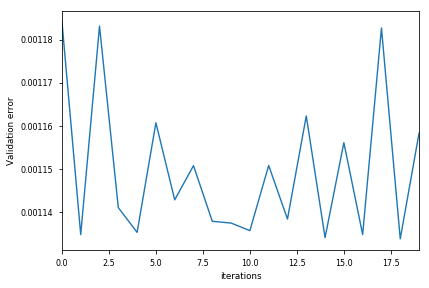

In [76]:
global counter

counter = 0

training_wrapper(batch_size=1024,num_epochs=20,input_file_list=os.listdir('mfcc'),out_vector=v_labels.reshape([-1,1]),alpha = 0.005)


# Visualize plots on TB by uncommenting the following line

In [42]:
!tensorboard --logdir /home/bhargav/Documents/VAD/model/losslog

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
E0425 00:29:42.835352 MainThread program.py:280] TensorBoard attempted to bind to port 6006, but it was already in use
TensorBoard attempted to bind to port 6006, but it was already in use


# LSTM Implementation

## Similar steps but change the model function and the placeholder dimensions according to the timesteps, number of inputs and the hidden units required

In [43]:
from tensorflow.contrib import rnn

In [44]:
def RNN(x, params, timesteps):


    x = tf.unstack(x, timesteps, 1)
    
    # Define a lstm cell with tensorflow
    #hidden units hard-coded for now
    lstm_cell = rnn.BasicLSTMCell(10, forget_bias=1.0)

    # Get lstm cell output
    outputs, _ = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    return tf.matmul(outputs[-1], params['Wout']) + params['bout']

In [45]:
def initialize_rnn_params():
    
    params = {}
    
    params['Wout'] = tf.Variable(tf.truncated_normal([10,1],stddev=0.01,dtype=tf.float32))
    params['bout'] = tf.Variable(tf.constant(1.0,shape=[1]))
    
    return params

 Can combine this with previous training pipeline by introducing a 'isRecurrent' flag, but for now, I wanted to keep both the models separate for readability purpose. 

However, it does use same helpers as Feedforward DNN

In [46]:
def train_rnn(X_mat,Y_mat, alpha , num_epochs, timesteps, ckpt_dir, batch_size = 256, shuffle_data = True ):
    random.seed(random.randint(0,10000))
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, timesteps, 1])
    Y = tf.placeholder(tf.float32, [None, 1])  #1 output label open
    
    
    parameters=initialize_params()
    prediction = RNN(X, parameters,timesteps)
    
    with tf.name_scope("loss"):
        cost = tf.reduce_mean(tf.losses.mean_squared_error(Y, prediction))
    optimizer = tf.train.RMSPropOptimizer(alpha).minimize(cost)
    epoch_count = 0
    with tf.name_scope("calc_loss"):
        calc_loss=tf.placeholder('float',name="calc_loss")
    with tf.name_scope("batch_L"):
        batch_L=tf.placeholder('float',name="batch_L")
    with tf.name_scope("overall"):
        overall = tf.truediv(calc_loss,batch_L,"overall")
        
    
    sess=tf.Session()
    
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    summary_writer=tf.summary.FileWriter(os.path.join(ckpt_dir,"losslog"),sess.graph)
    overall_loss = 0
    tf.summary.scalar("calc_loss",calc_loss)
    tf.summary.scalar("batch_L",batch_L)
    tf.summary.scalar("overall", overall)
    tf.summary.scalar("loss", cost)
    summ_op = tf.summary.merge_all()
    X_train, X_val, y_train, y_val = train_test_split(X_mat, Y_mat, test_size=0.1, random_state=1)
    print(X_val.shape[0], " number of frames are used for validation")
    num_batches = X_train.shape[0]//batch_size
    L = 1
    val_loss = []
    for epoch in range(num_epochs):
        start_time = time.time()
        counter = 0
        if shuffle_data:
            X_train,y_train = shuffle(X_train,y_train,random_state=0)
        X_val = X_val.reshape((X_val.shape[0],timesteps,1))
        gen_obj = next_batch(X_train,y_train,batch_size)
        for i in range(num_batches):
            #x_batch,y_batch = next_batch(X_train,y_train,batch_size)
            try:
                x_batch,y_batch = next(gen_obj)
            except IndexError:
                break
            assert x_batch.shape[0] == y_batch.shape[0]
            x_batch = x_batch.reshape((batch_size, 60, 1))
            over = sess.run(overall, feed_dict={calc_loss:float(overall_loss),batch_L:float(L)})
            summ, minibatchloss,summ = sess.run([optimizer, cost,summ_op], feed_dict={X: x_batch , Y: y_batch,
                                                                             calc_loss:float(overall_loss),batch_L:float(L)})
            summary_writer.add_summary(summ, (epoch))
            
            end_time = time.time()
            overall_loss += minibatchloss
            L += 1
        print( "Epoch ",epoch+1, "Finishes","Training loss:",overall_loss/L, "Time:", (end_time - start_time) )
        if ( epoch % 5 ) == 0:
            saver.save(sess,os.path.join(ckpt_dir,"mymodel.ckpt"))                
            print ( "The model parameters have been put in a checkpoint for epoch ", epoch )
            epoch_count = epoch_count + 1
        val_loss.append(sess.run(cost, feed_dict= {X: X_val, Y: y_val}))
    print("Validation error: ",val_loss)
    saver.save(sess,os.path.join(ckpt_dir,"mymodel.ckpt"))
    sess.close()
    print( "The model parameters are saved" )
    return val_loss

In [47]:
def training_wrapper_for_rnn(batch_size,num_epochs,input_file_list,out_vector,alpha,timesteps):
    if not os.path.exists(os.path.join(os.getcwd(),'rnn_model')):
        os.mkdir('rnn_model')
    #train_data_gens = [ data_generator(input_file_list, batch_size, out_vector, inp_dim = 60) 
    #                   for epoch in range( num_epochs ) ]
    X_data = get_all_frames(input_file_list,inp_dim=n_dct,total_frames = out_vector.shape[0])
    validation_error = train_rnn(X_data,out_vector, alpha, num_epochs, timesteps,
                                            ckpt_dir = os.path.join(os.getcwd(),'rnn_model'),batch_size=batch_size)
    plot_validation(validation_error)

60751  number of frames are used for validation
Epoch  1 Finishes Training loss: 0.013623521442735247 Time: 22.237134218215942
The model parameters have been put in a checkpoint for epoch  0
Epoch  2 Finishes Training loss: 0.0072066017503978844 Time: 20.492213249206543
Epoch  3 Finishes Training loss: 0.005152087373931548 Time: 19.486629724502563
Epoch  4 Finishes Training loss: 0.00422982342370399 Time: 19.217102766036987
Epoch  5 Finishes Training loss: 0.0035765809893521347 Time: 19.926255702972412
Epoch  6 Finishes Training loss: 0.0032522000054363088 Time: 19.630273818969727
The model parameters have been put in a checkpoint for epoch  5
Epoch  7 Finishes Training loss: 0.002912238052925544 Time: 20.277061700820923
Epoch  8 Finishes Training loss: 0.0027188181636546385 Time: 20.453020572662354
Epoch  9 Finishes Training loss: 0.0025483908130009498 Time: 20.069096326828003
Epoch  10 Finishes Training loss: 0.0023870687052982738 Time: 20.177459001541138
Epoch  11 Finishes Training 

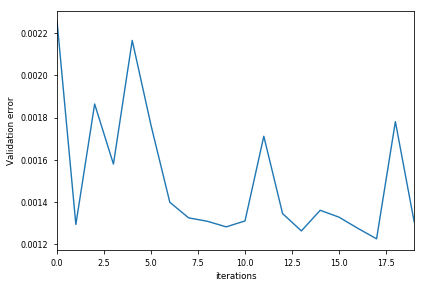

In [48]:
training_wrapper_for_rnn(batch_size=512,num_epochs=20,input_file_list=os.listdir('mfcc'),
                 out_vector=v_labels.reshape([-1,1]),alpha = 0.005,timesteps = n_dct)

# TO-DO and suggestions:

## * We could log all our training parameters like learning rate, batch size, optimizer, epochs, etc., in a configuration.ini file so we can go back and change

## * The validation plots suggest that we still can do better although we have an acceptable training loss trend. 


## * More layers in the network will definitely yield a better model

## * With access to GPU/cloud compute, one can leverage the power of more data which will help prevent overfitting for a given fixed model

## * Using decayed learning rate throughout or changing the learning rate in different layers 

## Collecting and comparing results from different types of features extracted (pitch contours, log spectrogram etc)

## Could use libraries like Librosa for readily extracting mfcc, but had issues with installations on anaconda so didn't explore

## ================end====================

In [87]:
sf.__version__

'0.10.2'